[INFO] Using 107919 rows
[INFO] Train time: 0.217s

=== Train Set ===
                  Target     R2       RMSE        MAE
voltage_rise_time_pulse1 0.9147 1.1761e-09 8.9180e-10
voltage_rise_time_pulse2 0.6275 2.7007e-09 1.3897e-09
voltage_fall_time_pulse1 0.9824 9.0433e-10 6.8701e-10
voltage_fall_time_pulse2 0.9824 9.0327e-10 6.8611e-10
current_rise_time_pulse1 0.8851 1.5994e-08 1.0679e-08
current_rise_time_pulse2 0.7822 1.2403e-08 9.6649e-09
current_fall_time_pulse1 0.9633 2.4584e-09 1.8738e-09
current_fall_time_pulse2 0.9629 2.4705e-09 1.8869e-09
       overshoot_pulse_1 0.8410 5.3695e+00 3.9913e+00
       overshoot_pulse_2 0.8292 1.1026e+01 8.4365e+00
      undershoot_pulse_1 0.8779 4.7448e+00 3.2630e+00
      undershoot_pulse_2 0.8796 4.7084e+00 3.2597e+00
   ringing_frequency_MHz 0.9949 2.2975e+00 1.6132e+00
R2_avg          0.8864
RMSE_avg    2.1651e+00
MAE_avg     1.5818e+00
dtype: object
Predict Time (ms/sample): 0.0012

=== Validation Set ===
                  Target     R2   

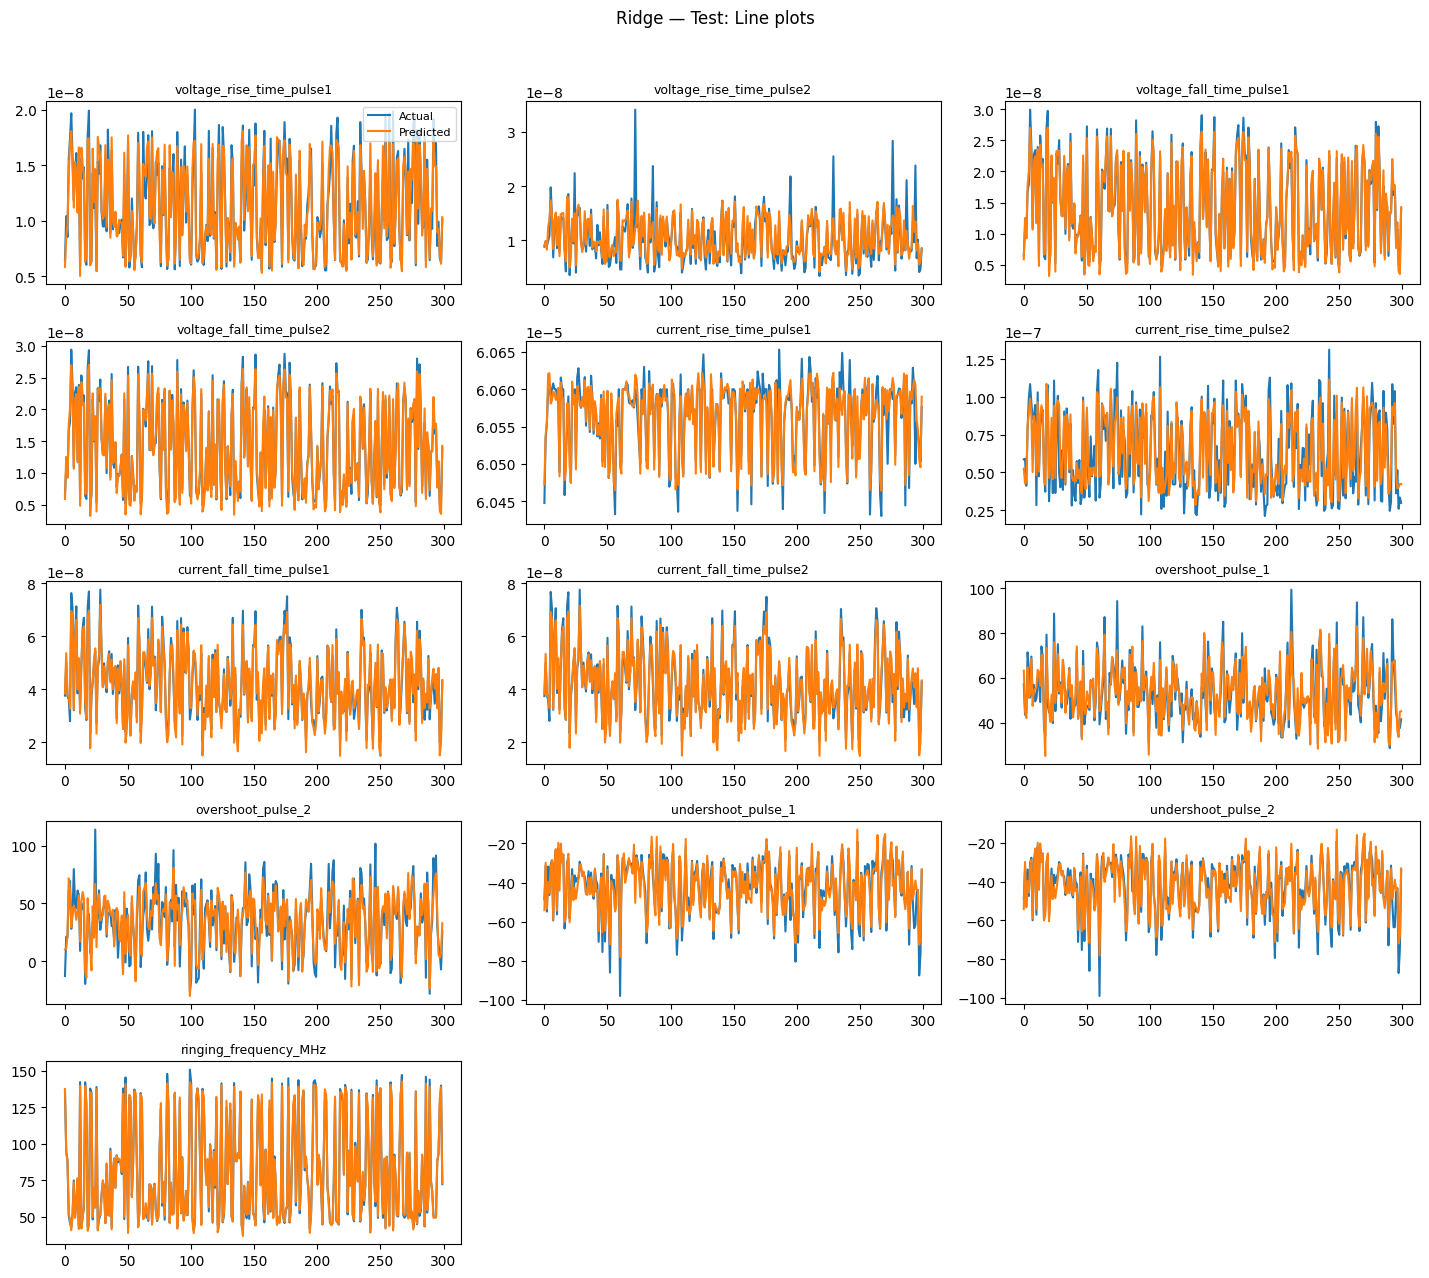

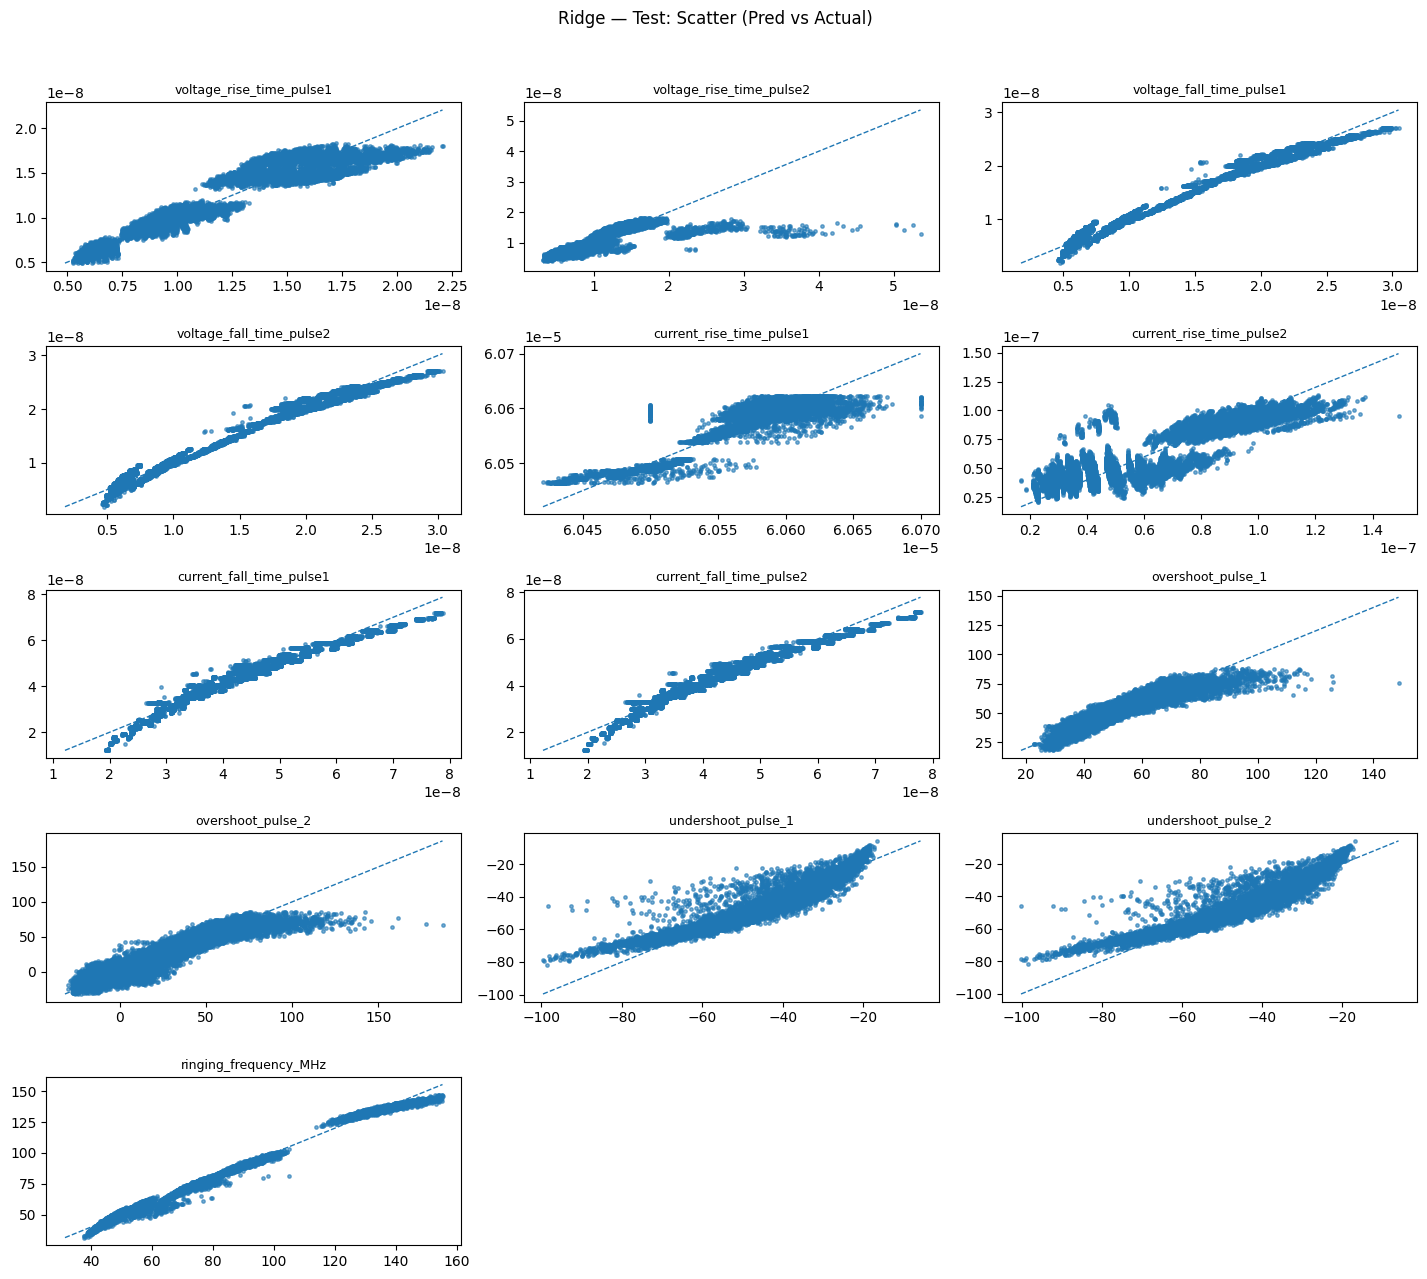

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ============== Settings ==============
DATA_FILE = r"C:\Users\pc\Desktop\Classical_Models\MERGED_ORIGINAL\Train_5_MOSFETs.csv"
FAST_MODE = True            # 25% sample for speed
FAST_SEED = 42
FAST_FRAC = 0.25

TARGETS = [
    'voltage_rise_time_pulse1','voltage_rise_time_pulse2',
    'voltage_fall_time_pulse1','voltage_fall_time_pulse2',
    'current_rise_time_pulse1','current_rise_time_pulse2',
    'current_fall_time_pulse1','current_fall_time_pulse2',
    'overshoot_pulse_1','overshoot_pulse_2',
    'undershoot_pulse_1','undershoot_pulse_2',
    'ringing_frequency_MHz'
]
CAT_COLS = ['Part_Number']  # categorical
# =====================================

# --- Load ---
df = pd.read_csv(DATA_FILE).dropna(subset=TARGETS).reset_index(drop=True)
if FAST_MODE:
    df = df.sample(frac=FAST_FRAC, random_state=FAST_SEED).reset_index(drop=True)
print(f"[INFO] Using {len(df)} rows")

# --- Features / Targets ---
X = df.drop(columns=TARGETS)
y = df[TARGETS].values

num_cols = [c for c in X.columns if c not in CAT_COLS]

# --- OneHotEncoder compatibility (sklearn >=1.4 uses sparse_output) ---
def make_ohe():
    try:
        # Newer versions
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        # Older versions
        return OneHotEncoder(handle_unknown='ignore', sparse=False)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", make_ohe(), CAT_COLS)
    ],
    remainder="drop"
)

model = Pipeline([
    ("preprocessor", pre),
    ("regressor", Ridge(alpha=1.0, random_state=FAST_SEED))  # Ridge natively supports multi-output
])

# --- Split 70/15/15 ---
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=FAST_SEED, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=FAST_SEED, shuffle=True)

# --- Train ---
t0 = time.time()
model.fit(X_train, y_train)
train_time = time.time() - t0
print(f"[INFO] Train time: {train_time:.3f}s")

# --- Helpers ---
def eval_block(name, Xs, ys):
    t0 = time.time()
    y_pred = model.predict(Xs)
    ms_per_sample = (time.time() - t0) / max(1, len(Xs)) * 1000.0

    rows = []
    for i, t in enumerate(TARGETS):
        yt, yp = ys[:, i], y_pred[:, i]
        r2  = r2_score(yt, yp)
        rmse = np.sqrt(mean_squared_error(yt, yp))
        mae  = mean_absolute_error(yt, yp)
        rows.append([t, f"{r2:.4f}", f"{rmse:.4e}", f"{mae:.4e}"])
    dfm = pd.DataFrame(rows, columns=["Target","R2","RMSE","MAE"])

    r2_avg  = f"{np.mean(dfm['R2'].astype(float)):.4f}"
    rmse_avg = f"{np.mean(dfm['RMSE'].astype(float)):.4e}"
    mae_avg  = f"{np.mean(dfm['MAE'].astype(float)):.4e}"

    print(f"\n=== {name} ===")
    print(dfm.to_string(index=False))
    print(pd.Series({"R2_avg": r2_avg, "RMSE_avg": rmse_avg, "MAE_avg": mae_avg}))
    print(f"Predict Time (ms/sample): {ms_per_sample:.4f}")
    return y_pred

def plot_line_grid(y_true, y_pred, title, n_cols=3, max_points=300):
    n_targets = len(TARGETS)
    n_rows = int(np.ceil(n_targets / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.8*n_cols, 2.6*n_rows))
    axes = axes.flatten()
    idx = np.linspace(0, len(y_true)-1, min(max_points, len(y_true))).astype(int)

    for i, t in enumerate(TARGETS):
        ax = axes[i]
        ax.plot(y_true[idx, i], label="Actual")
        ax.plot(y_pred[idx, i], label="Predicted")
        ax.set_title(t, fontsize=9)
        if i == 0:
            ax.legend(fontsize=8)
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    plt.suptitle(title, fontsize=12)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

def plot_scatter_grid(y_true, y_pred, title, n_cols=3):
    n_targets = len(TARGETS)
    n_rows = int(np.ceil(n_targets / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.8*n_cols, 2.6*n_rows))
    axes = axes.flatten()

    for i, t in enumerate(TARGETS):
        ax = axes[i]
        ax.scatter(y_true[:, i], y_pred[:, i], s=6, alpha=0.6)
        mn = min(y_true[:, i].min(), y_pred[:, i].min())
        mx = max(y_true[:, i].max(), y_pred[:, i].max())
        ax.plot([mn, mx], [mn, mx], '--', lw=1)
        ax.set_title(t, fontsize=9)
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    plt.suptitle(title, fontsize=12)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

# --- Evaluate ---
y_tr_pred = eval_block("Train Set", X_train, y_train)
y_va_pred = eval_block("Validation Set", X_val, y_val)
y_te_pred = eval_block("Test Set", X_test, y_test)

# --- Plots (Test set) ---
plot_line_grid(y_test, y_te_pred, "Ridge — Test: Line plots")
plot_scatter_grid(y_test, y_te_pred, "Ridge — Test: Scatter (Pred vs Actual)")
